# Introduction

This is the first Kaggle competition I participate, and the first time series I try to model. I did not look at the forums of discussions and the codes of other participants because I wanted to crack my head in this first challenge, learning was my first priority. In addition, since I am  doing this as part of the _Google Developer Machine Learning Bootcamp_, I thought it would be better to do it alone.

This problem is about modelling and predicting the sales of 4 different books, from 2 different stores in 6 different countries between 2017 and 2020, and then to predict the sales in 2021. At first the dataset seems complicated, but after a lot of feature analysis one can see that it is actually quite simple. The difficult part is trying to extrapolate the effects of the 2020 year, since the pattern found between 2017-2019 changed significantly in 2020.

There are no missing or duplicated observations in the dataset, it is annoyingly balanced, and every category has precisely the same number of observations. The main approach presented is:

1. Model the fraction of sales of each category as a function of time. The number of sales of each product/store/country changed a lot between 2017-2019 and 2020. However, the fraction of sales did not change so much. In fact, except for the _country_ feature, only minor changes were found between the 2017-2019 years and 2020. 

2. Model the total sales as a function of time. This is a time series with trend and periodicity, and despite the difficult 2020 year, if one focuses only on the total number of books sold per day, it is not so complicated.

3. Model the sales of each product/store/country in 2021, using the fraction from (1) and the total sales in (2).

It is not a difficult problem, and getting reasonable results does not take too much time. If one wants to get the best possible model, however, than things get much more complicated and exciting. There is a lot of room for feature engineering, and many things to try.

## Libraries and functions

Importing the libraries and loading the datasets.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy.stats import probplot, boxcox
from scipy.special import inv_boxcox
import scipy.optimize
from scipy.fft import fft, ifft

from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_absolute_error,mean_squared_error,make_scorer

from datetime import date
import holidays
from workalendar.europe import Germany,Belgium,Spain,Poland,Italy,France

Some convenient dictionaries and functions are defined:

In [2]:
#The SMAPE metrics (https://www.kaggle.com/cpmpml/smape-weirdness)
def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 200.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return np.nanmean(diff)


# Dictionary to transform the weekday
dict_toweekday = {0:"Monday",1:"Tuesday",2:"Wednesday",3:"Thursday",
                  4:"Friday",5:"Saturday",6:"Sunday"}


# Dictionary to transform the month number
dict_tomonth = {1: "January", 2: "February", 3: "March", 4: "April", 
                5: "May", 6: "June",7: "July", 8: "August", 
                9: "September", 10: "October", 11: "November", 12: "December"}


# Gaussian centered at point mu, with square variance of sigma
def gaussians(x,mu,sigma):
    return np.exp(-0.5*(x-mu)**2 / (sigma**2))


# Fitting a sine function to the data / providing an initial guess p0 to help the algorithm
def fit_sine(x,y,period):
    def sinfunc(t, A, phase, c):  
        return A * np.sin(2*3.14159*t/period + phase) + c
    param, covariance = scipy.optimize.curve_fit(sinfunc,x,y,p0=[-100,0,300])
    A, p, c= param
    return A, p, c


# Function to plot the predicted and true values
def compare_pred(df,model):
    df_temp=df.copy()
    df_temp['sum_sales_day_pred']=model.predict()
    f,(ax1,ax2)=plt.subplots(nrows=1, ncols=2, figsize=(12,6))
    sns.lineplot(ax=ax1,data=df_temp,x='time_days',y='sum_sales_day',linewidth = 1.5,ci=None)
    sns.lineplot(ax=ax1,data=df_temp,x='time_days',y='sum_sales_day_pred',linewidth = 1.5,ci=None)
    sns.lineplot(ax=ax2,data=df_temp,x='time_days',y='sum_sales_day',linewidth = 1.5,ci=None)
    sns.lineplot(ax=ax2,data=df_temp,x='time_days',y='sum_sales_day_pred',linewidth = 1.5,ci=None)    
    ax2.set_xlim(0,200); # Zoom in
    f.tight_layout();

Reading the dataset:

In [3]:
df_train = pd.read_csv('./train.csv').drop('row_id', axis=1)

A quick analysis of the categorical features reveal that they are no missing or duplicate values. In addition, they are well balanced, meaning that each of the three categories is equally represented. 

Let's focus first on the date, extracting the year, month, weekday, week of the year and the running time in weeks starting from 2017, our earliest data point.

In [4]:
def prepare_df(df):
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['dayofyear'] = df['date'].dt.dayofyear
    df['weekday'] = df['date'].dt.weekday
    df['time_days'] = (df['date']-pd.Timestamp(2017,1,1)).dt.days + 1
    df['time_weeks'] = df['time_days'] // 7
    return df

In [5]:
df_train = prepare_df(df_train)

Checking how the sales behave as a function of time.

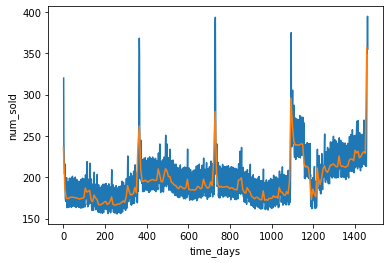

In [6]:
sns.lineplot(data=df_train,x='time_days',y='num_sold',ci=None);
sns.lineplot(data=df_train,x=7*(df_train.time_weeks),y='num_sold',ci=None);

We have trend and seasonality. Overall, the sales increase over time, and the periodic/cyclic patterns are clear, except for the 2020 year that shows a different special pattern.

# Fourier Transform

Let's make a Fourier transform to extract the most relevant frequencies. Grouping and averaging the data for each day of the time series and evaluating the Fourir transform:

In [7]:
# Function to evaluate the Fourier transform
def eval_fft(df):
    # Sum of sales at each day, from 1 (01/01/2017) to 1461 (31/12/2020)
    num_sold=df.groupby(by='time_days').sum()['num_sold'].values 
    df_ft=pd.DataFrame(num_sold,columns=['num_sold'])
    df_ft['freq']=(df_ft.index+1)/1461
    df_ft['fft']=np.abs(fft(df_ft.num_sold.values))
    return df_ft

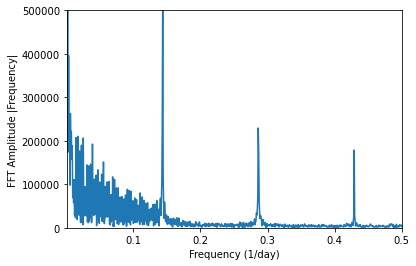

In [8]:
data=eval_fft(df_train)
plt.plot(data.freq,data.fft)
plt.xlabel('Frequency (1/day)');
plt.ylabel('FFT Amplitude |Frequency|');
plt.xlim(0.001,0.50);
plt.ylim(0.0,5e5);

The range in the X-axis was chosen as to analyze periods between 2 days periodicity (frequency of 0.5) and 2 years (frequency of 0.0014). So the main peak obtained is found at 0.1435, which gives a period of 7 days. The other peaks at 0.28 and 0.42 correspond to half of a week and a third of a week. Looking closely at the low frequency range (longer periodicities):

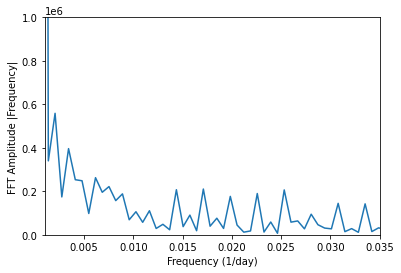

In [9]:
plt.plot(data.freq,data.fft)
plt.xlabel('Frequency (1/day)');
plt.ylabel('FFT Amplitude |Frequency|');
plt.xlim(0.001,0.035);
plt.ylim(0.0,1e6);

There is one clear narrow 0.0014, corresponding to 2 years periodicity. Then there are a few other peaks with increasingly lower magnitudes, the most relevant ones at frequencies of 0.0028/0.0035, which correspond to 1/0.5 year periodicity, respectively. The fact that the two largest frequencies peaks correspond to periods of 7 days and 2 years is very important, and will be of relevance later on.

The main approach is: predict first the fraction of sales given a product, store and country, using XGBoost. Then the total number of sales as a function of time will be predicted with a linear/parabollic regression using Statsmodel. These 2 predictions will then be combined to predict the number of units sold per store, country and product in 2021.

# Fraction of sales

To model the fraction of the predicted sales for each categorical feature, let's fist evaluate the total fraction and fractions per store/country/product. Then each feature is analyzed separately.

In [10]:
df_train['fraction']=df_train['num_sold'] / df_train.groupby('time_days')['num_sold'].transform('sum')

df_train['fraction_store']=df_train.groupby(['time_days','store']).fraction.transform('sum')
df_train['fraction_country']=df_train.groupby(['time_days','country']).fraction.transform('sum')
df_train['fraction_product']=df_train.groupby(['time_days','product']).fraction.transform('sum')

## Store

For the 2 different types of stores, one has the following behavior of the fraction of sales as a function of time:

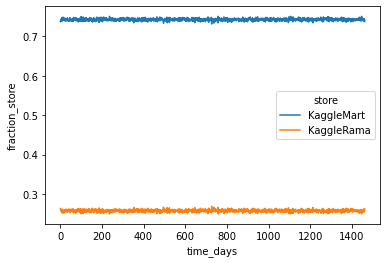

In [11]:
sns.lineplot(data=df_train,x='time_days',y='fraction_store',hue='store',ci=None);

Nearly constant for all years, even 2020. This is good. So a single feature should be able to accurately model this.

## Country

For the countries, the ratio between the sales of each country seems to be constant, except for Poland, that has a small slope. In 2020, however, this completely changes.

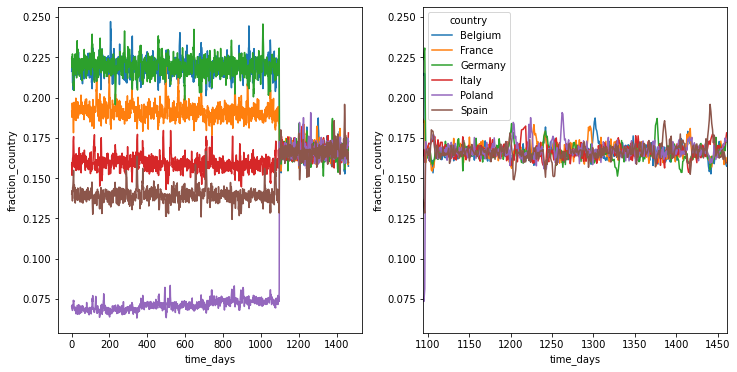

In [12]:
f,ax=plt.subplots(nrows=1,ncols=2,figsize=(12,6))
sns.lineplot(ax=ax[0],data=df_train,x='time_days',y='fraction_country',hue='country',ci=None,legend=False);
sns.lineplot(ax=ax[1],data=df_train,x='time_days',y='fraction_country',hue='country',ci=None);
ax[1].set_xlim(1094,1462);

Important: will all the countries show approximately the same ratio in sales after 2020, or the pattern will be again like in 2017-2019? Or an average between these two? Difficult to know. It is assumed in this notebook that this 2020 change was permanent, so all countries will have approximately the same fraction. This will be modelled with a special weight for the countries in 2020 and beyond.

Furthermore, even though the ratios are quite similar, they do change a bit in some days of the year. These are probably connected to the holidays of each month, where some countries show higher sales than others. One can explicitly add the holidays in this fist part of the notebook. In this notebook, however, this was not done, and the holidays were simulated using general features for each country.

## Product

The products show a sinusoidal behavior. It is not complicated, and the good thing is that it does not change in 2020.

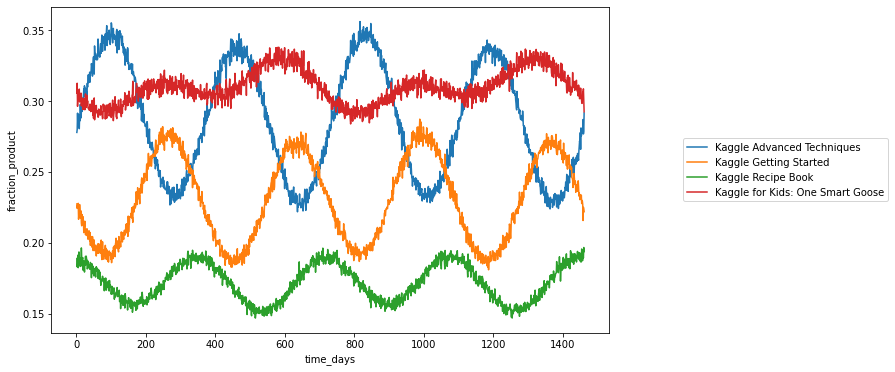

In [13]:
plt.figure(figsize=(10,6))
sns.lineplot(data=df_train,x='time_days',y='fraction_product',hue='product',ci=None);
plt.legend(bbox_to_anchor=(1.5, 0.5), loc='right', borderaxespad=0);

The periodicity is 2 years, except for the "Recipe Book" that seems to have a 1-year periodicity. Regardless, with a linear combination of two sine functions, one with a 1-year and another one with a 2-years periodicity, this behavior can be accurately simulated.

## Model: All 3 categories combined

The 3 categorical features can be dealt separately, there seems to be no need of testing for combinations between them. Furthermore, all the assumptions about 2021 should come from the _country_ feature only, since for both _product_ and _store_ features the behavior in 2020 is the same as in the other years.

Let's start modelling. Given a country, store and product the goal is to predict the fraction of the total sales for each category at each day, starting from 2017. Some considerations:

1. Many features do not need to be taken into account when consideraing ratios. For example, the week periodicity. Even though the number of sales change every day of the week, the ratio remains nearly the same.

2. For the store, a single feature will be used. The ML model should evaluate the best linear weight between them.

3. For the countries, the years of 2017-2019 will be separated from 2020 using a special weight for the 2020 year, named _covid_. 

4. For the products, sinusoidal functions with 1/2-years periodicity will be used to fit the curve.

5. An additional _cross_ feature is required to take into account the sudden change in the country sales that occur in the 01/01/2020 day.

Let's create the features:

In [14]:
df_train['covid']=df_train.date.apply(lambda x: 1 if (x >= pd.Timestamp(2020,1,1)) else 0)
df_train['cross']=df_train.date.apply(lambda x: 1 if (x == pd.Timestamp(2020,1,1)) else 0)

In [15]:
df_frac = df_train.drop(columns=['date','num_sold','time_weeks','dayofyear','month','weekday',
                                 'fraction_store','fraction_country','fraction_product']).copy()

In [16]:
# Product
def sinfunc2(t, A1, phase1, A2, phase2, c):  
    return A1 * np.sin(2*3.14159*t/365 + phase1) + A2 * np.sin(2*3.14159*t/730 + phase2) + c

# Fitting a sine function to the data / providing an initial guess p0 to help the algorithm
params=[]
name_products=df_frac['product'].unique()
for product in name_products:
    name=product+"_sine"
    df=df_frac[df_frac['product'] == product]
    param, covariance = scipy.optimize.curve_fit(sinfunc2,df.time_days,df.fraction,p0=[0.001,0,0.003,0.001,0.025])
    params.append(param)
    df_frac[name]=sinfunc2(df_frac.time_days,param[0],param[1],param[2],param[3],param[4])

Let's check the sinusoidal functions and the fit to the curve.

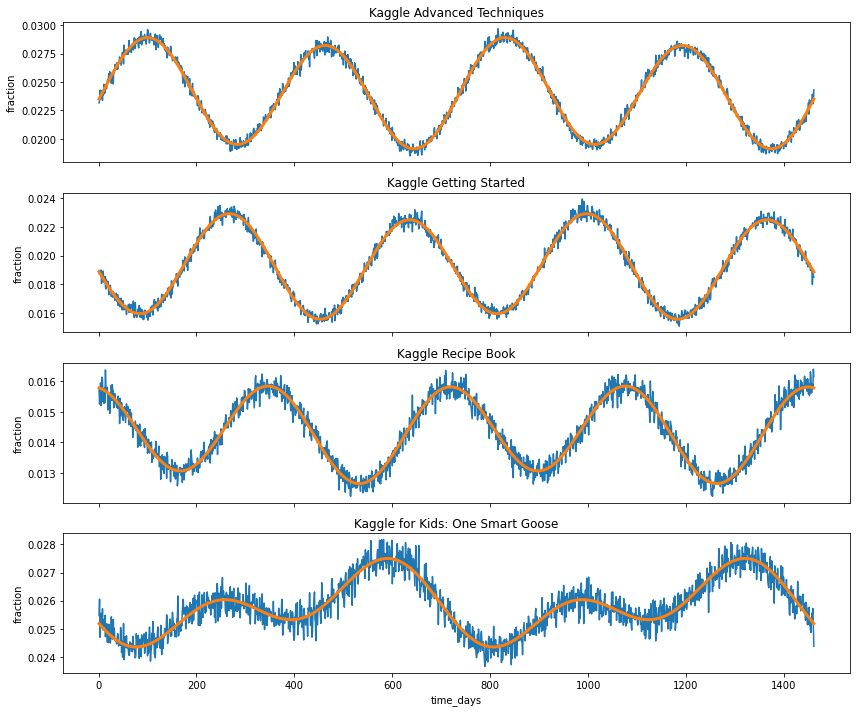

In [17]:
f,ax=plt.subplots(4,figsize=(12,10),sharex=True)
for i in range(4):
    name_products=df_frac['product'].unique()
    df=df_frac[df_frac['product'] == name_products[i]]
    sns.lineplot(ax=ax[i],data=df,x='time_days',y='fraction',ci=None);
    name=name_products[i]+"_sine"
    sns.lineplot(ax=ax[i],data=df_frac,x='time_days',y=name,ci=None,linewidth=3).set(title=name_products[i]);
f.tight_layout();

A good fit. The final weights of all added features will be adjusted by the ML model.

In [18]:
df_frac=pd.get_dummies(df_frac)
df_frac.drop(columns=['year','time_days',
                      'product_Kaggle Getting Started','store_KaggleMart'],inplace=True)

In [19]:
X=df_frac.drop(columns=['fraction'])    
y=df_frac.fraction

bc_result = boxcox(y)
y_bc = bc_result[0]
lam = bc_result[1]

The final X matrix has the following dimensions and features:

In [20]:
print(X.shape)
print(X.columns)

(70128, 16)
Index(['covid', 'cross', 'Kaggle Advanced Techniques_sine',
       'Kaggle Getting Started_sine', 'Kaggle Recipe Book_sine',
       'Kaggle for Kids: One Smart Goose_sine', 'country_Belgium',
       'country_France', 'country_Germany', 'country_Italy', 'country_Poland',
       'country_Spain', 'store_KaggleRama',
       'product_Kaggle Advanced Techniques', 'product_Kaggle Recipe Book',
       'product_Kaggle for Kids: One Smart Goose'],
      dtype='object')


## Modelling

KFold will be used. This is a stationary series, and there is no "time" evolution, so one can randomly split to check for the accuracy.

In [21]:
cv = KFold(n_splits=5, random_state=55, shuffle=True)
param_grid = {   'depth'         : [4,6],
                 'learning_rate' : [0.1,0.2],
                 'n_estimators'  : [200,350,500],
                 'l2_leaf_reg'   : [1]
             }

model = CatBoostRegressor(silent=True);
model_cv = GridSearchCV(model,param_grid,n_jobs=-1,cv=cv)

#model_cv.fit(X,y_bc)

In [22]:
#print(model_cv.best_params_)
#results=pd.DataFrame(model_cv.cv_results_)
#results[['params','mean_test_score','rank_test_score']]

The performance is pretty similar between all hyperparameters. Indeed, a much better grid search was done in previous notebooks, but it was found that the main results did not chage significantly, except when for a higher number of estimators there is a strong overfitting, with a very good accuracy in training and very weird predicitons for 2021. The SMAPE value of this first part is:

In [24]:
#predictions = inv_boxcox(model_cv.predict(X),lam)

#print("RMSE: ",np.sqrt(mean_squared_error(y,predictions)))
#print("MAE: ",mean_absolute_error(y,predictions))
#print("SMAPE: ",smape(y,predictions))

A good overall accuracy, and in line with the final SMAPE value obtained after submitting the notebook.

## Feature importance

Checking what are the most important variables.

In [25]:
model = CatBoostRegressor(n_estimators=500,depth=6,learning_rate=0.2,l2_leaf_reg=1,silent=True);
model.fit(X,y_bc);

predictions = inv_boxcox(model.predict(X),lam)
print("RMSE: ",np.sqrt(mean_squared_error(y,predictions)))
print("MAE: ",mean_absolute_error(y,predictions))
print("SMAPE: ",smape(y,predictions))

RMSE:  0.0012065768220160453
MAE:  0.000824335894298856
SMAPE:  4.042851790121754


In [26]:
pd.Series(data=model.feature_importances_,index=X.columns).sort_values(ascending=False)

store_KaggleRama                            56.126829
country_Poland                              18.938337
product_Kaggle Recipe Book                   6.095511
covid                                        5.455479
product_Kaggle Advanced Techniques           3.221193
product_Kaggle for Kids: One Smart Goose     2.816541
country_Spain                                2.460099
Kaggle Advanced Techniques_sine              1.488630
country_Italy                                0.951657
country_Belgium                              0.873230
country_Germany                              0.849007
Kaggle Recipe Book_sine                      0.245757
Kaggle Getting Started_sine                  0.224051
Kaggle for Kids: One Smart Goose_sine        0.129930
country_France                               0.109537
cross                                        0.014211
dtype: float64

These results seem quite reasonable. The store category is represented by a single feature, and it is very important, in a straightforward way, so it should have more weight than the others. The country and product variables are all important also, although a bit less due to the higher number of features required to accurately model them. LAst, all product features are important, since they simulate the periodic behavior.

## Visualizing the predictions

Let's visualize the _predicted versus true_ values for each category.

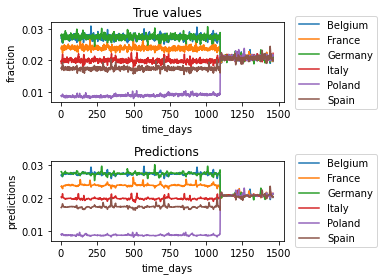

In [27]:
df_train['predictions']=predictions
f,(ax1,ax2)=plt.subplots(2)
sns.lineplot(data=df_train,x='time_days',y='fraction',ci=None,hue='country',ax=ax1).set_title('True values');
sns.lineplot(data=df_train,x='time_days',y='predictions',ci=None,hue='country',ax=ax2).set_title('Predictions');
ax1.legend(bbox_to_anchor=(1.4, 0.5), loc='center right', borderaxespad=0);
ax2.legend(bbox_to_anchor=(1.4, 0.5), loc='center right', borderaxespad=0);
f.tight_layout();

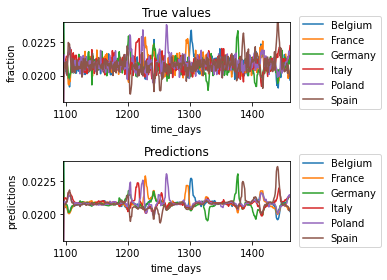

In [28]:
# Zoom in the 2020 year
f,(ax1,ax2)=plt.subplots(2)
sns.lineplot(data=df_train,x='time_days',y='fraction',ci=None,hue='country',ax=ax1).set_title('True values');
sns.lineplot(data=df_train,x='time_days',y='predictions',ci=None,hue='country',ax=ax2).set_title('Predictions');
ax1.legend(bbox_to_anchor=(1.4, 0.5), loc='center right', borderaxespad=0);
ax2.legend(bbox_to_anchor=(1.4, 0.5), loc='center right', borderaxespad=0);
ax1.set_xlim(1096,1461);ax1.set_ylim(0.018,0.024);
ax2.set_xlim(1096,1461);ax2.set_ylim(0.018,0.024);
f.tight_layout();

Reasonable, and most peaks are well reproduced. There is a lot of noise not reproduced by the model, a good thing. Increasing the number of estimators increase the noise and result in much better SMAPE values, but the predicitons of 2021 worsen, a clear sign of overfit.

Let's check the predicted fractions:

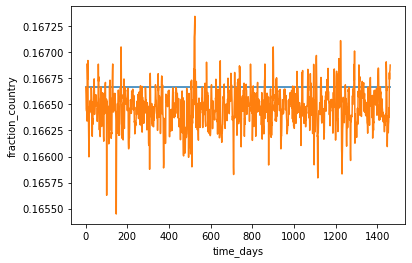

In [29]:
df_train['pred_fraction_country']=df_train.groupby(['time_days','country']).predictions.transform('sum')
sns.lineplot(data=df_train,x='time_days',y='fraction_country',ci=None);
sns.lineplot(data=df_train,x='time_days',y='pred_fraction_country',ci=None);

The predicted fractions for each country are a bit slower than the true value, but the deviations are smaller than 1%.

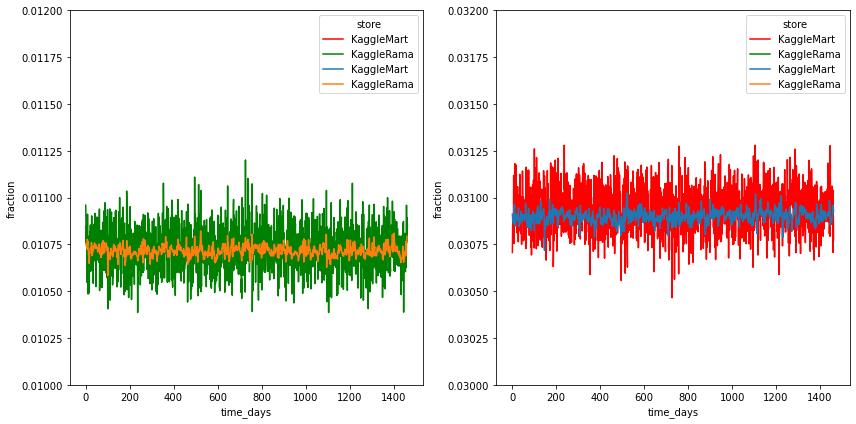

In [30]:
f,ax=plt.subplots(nrows=1,ncols=2,figsize=(12,6))
sns.lineplot(ax=ax[0],data=df_train,x='time_days',y='fraction',ci=None,hue='store',palette=['r', 'g']);
sns.lineplot(ax=ax[0],data=df_train,x='time_days',y='predictions',ci=None,hue='store');
ax[0].set_ylim(0.010,0.012)
sns.lineplot(ax=ax[1],data=df_train,x='time_days',y='fraction',ci=None,hue='store',palette=['r', 'g']);
sns.lineplot(ax=ax[1],data=df_train,x='time_days',y='predictions',ci=None,hue='store');
ax[1].set_ylim(0.030,0.032);
f.tight_layout();

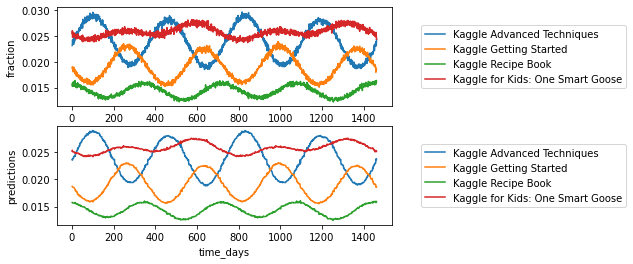

In [31]:
f,(ax1,ax2)=plt.subplots(2)
sns.lineplot(data=df_train,x='time_days',y='fraction',ci=None,hue='product',ax=ax1);
sns.lineplot(data=df_train,x='time_days',y='predictions',ci=None,hue='product',ax=ax2);
ax1.legend(bbox_to_anchor=(1.7, 0.5), loc='center right', borderaxespad=0);
ax2.legend(bbox_to_anchor=(1.7, 0.5), loc='center right', borderaxespad=0);

The sinusoidal behavior was well reproduced.

## Where do the errors come from?

Checking the source of the deviations, analyzing each categorical feature.

In [32]:
df_train['diff']=(df_train.fraction-df_train.predictions)

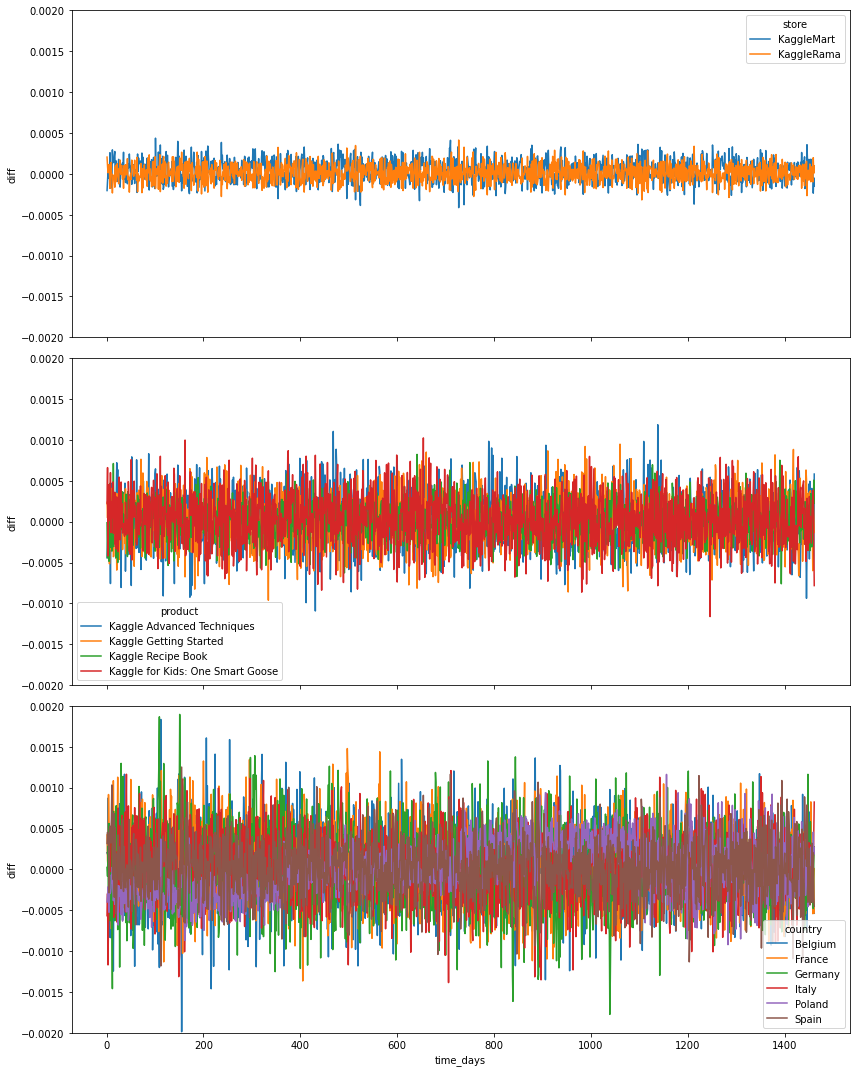

In [33]:
f,(ax1,ax2,ax3)=plt.subplots(3,figsize=(12,15),sharex=True)
sns.lineplot(ax=ax1,data=df_train,x='time_days',y='diff',ci=None,hue='store');
sns.lineplot(ax=ax2,data=df_train,x='time_days',y='diff',ci=None,hue='product');
sns.lineplot(ax=ax3,data=df_train,x='time_days',y='diff',ci=None,hue='country');
ax1.set_ylim(-0.002,0.002);ax2.set_ylim(-0.002,0.002);ax3.set_ylim(-0.002,0.002);
f.tight_layout();

So the largests deviations come from the _country_ feature, followed by the _store_ and _product_. The deviations are small, however, and seem constant. So everything could be ok.

## Prediction of the fractions for 2021

Now one can predict the fraction of sales for the year of 2021. Since the year of 2020 has 366 years, this has to be taken into account for the sinusoidal functions. Using a global varible for this:

In [34]:
leap_year = -1

Preparing the dataframe for the test set:

In [35]:
df_test = pd.read_csv('./test.csv').drop('row_id', axis=1)
df_test = prepare_df(df_test)

df_frac_test=df_test.drop(columns=['date','dayofyear','time_weeks','month','year','weekday']).copy()

df_frac_test['covid']=1
df_frac_test['cross']=0

# Fitting the sine functions again, since the optimizal parameters were not saved previously
for product in name_products:
    name=product+"_sine"
    df=df_train[df_train['product'] == product]
    param, covariance = scipy.optimize.curve_fit(sinfunc2,df.time_days,df.fraction,p0=[0.001,0,0.003,0.001,0.025])
    # Take into account the leap year
    df_frac_test[name]=sinfunc2((df_frac_test.time_days+leap_year),param[0],param[1],param[2],param[3],param[4])

df_frac_test=pd.get_dummies(df_frac_test)
df_frac_test.drop(columns=['time_days',
                           'product_Kaggle Getting Started','store_KaggleMart'],inplace=True)

In [36]:
predictions = inv_boxcox(model.predict(df_frac_test),lam)

df_test['predicted_fraction']=predictions

MAE:  0.0018168206279099955


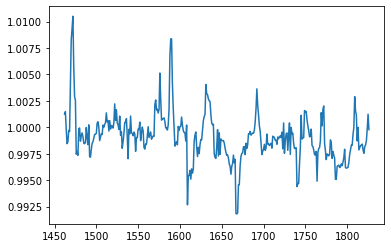

In [37]:
predicted_fraction_sum=df_test.groupby('time_days').predicted_fraction.sum()
print("MAE: ",np.abs(predicted_fraction_sum-1).sum() / len(predicted_fraction_sum))
plt.plot(predicted_fraction_sum);

The sum of the predicted fractions is almost 1 during the whole year. Not perfect, but not bad either, since no constraints were applied. The MAE is 0.0016, and this should be close to 0, since one does not want to artificially apply a constraint to keep the sum of fractions close to 1 at each day.

# Total sales as a function of time

With the contribution of each feature determined, it remains to evaluate how the total sales change over time. This is a non-sationary time series, since it has a clear trend and a non-constant deviation.

From the Fourier transform it was obtained a strongly weekly periodic motion, due to the sales in the weekends being higher than during the week (which makes sense). To check the overall increase in sales over time, let's remove this periodic motion by looking the the sales as a function of the week.

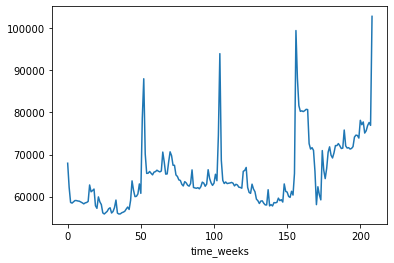

In [38]:
num_sold_weeks=df_train.groupby(by='time_weeks').sum()['num_sold']
sns.lineplot(data=num_sold_weeks,x=num_sold_weeks.index,y=num_sold_weeks.values);

A good approach to remove seasonality is to take the nth order derivative of a function. Starting with the first order derivative:

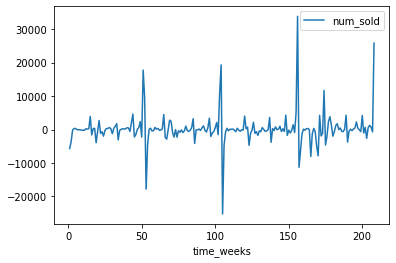

In [39]:
df_1stderiv=pd.DataFrame(num_sold_weeks.diff().iloc[1:])
df_1stderiv.plot();
df_1stderiv=df_1stderiv.reset_index()

Apparentely linear. Let's make a linear regression:

                            OLS Regression Results                            
Dep. Variable:               num_sold   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.037
Date:                Sat, 01 Oct 2022   Prob (F-statistic):              0.310
Time:                        17:10:05   Log-Likelihood:                -2056.3
No. Observations:                 208   AIC:                             4117.
Df Residuals:                     206   BIC:                             4123.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -419.7093    665.025     -0.631      0.5

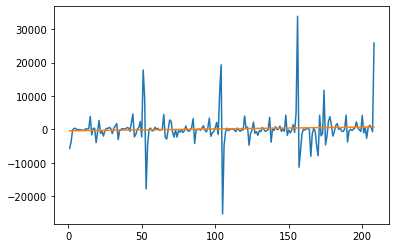

In [40]:
model_linear = smf.ols('num_sold ~ time_weeks', data = df_1stderiv).fit()
print(model_linear.summary())

plt.plot(df_1stderiv.time_weeks,df_1stderiv.num_sold);
plt.plot(df_1stderiv.time_weeks,model_linear.predict());

That was a bad fit. The F-statistic probability is large, and for the slope the standard error is as high as the coefficient. This is not good. However, other transformations and higher order derivatives did not seem to improve much the description. So let's suppose that this is indeed a straight line and the lack of accuracy is associated with the high fluctuations due to holidays, COVID, etc... If the derivative can be well described by a straight line with a slope different from zero, a 2nd order polynomial should fit well the original data. Again, since the slope is very small and its standard deviation is comparable to its value, one might argue that this is a straight line without a slope, so a linear fit in the real data would be better. Let's try both.

## 1st and 2nd-order fitting

In [41]:
df_days = df_train[['date','country','year','month','dayofyear','weekday','time_days','time_weeks',
                    'num_sold','covid']].copy()
df_train.groupby(by='time_days')['num_sold'].transform('sum')
df_days['sum_sales_day']=df_days.groupby(by='time_days')['num_sold'].transform('sum')
df_days.drop(columns='num_sold',inplace=True)

Since the approach is to model the total sales over time, let's focus only on the total sales as a function of the time features, ignoring all the others, such as the store and the product. Only the countries are kept, since they will be important to determine the holidays.

Removing duplicates and resetting the index. Focusing only on the total number of sales per day.

In [42]:
df_days.drop_duplicates(inplace=True)
df_days=df_days.reset_index(drop=True)

Let's add the name of each weekday and motth, to get more intutitive column names.

In [43]:
df_days['weekday']=df_days['weekday'].map(dict_toweekday)
df_days['month']=df_days['month'].map(dict_tomonth)

And let's also the months related to the COVID pandemic. We will consider a flag for pre-pandemia, for January and February when COVID started in China but was not in Europe yet. Than the lockdown restrictions between March-May, and then a recovery period later on. 

To take into account the 1/2-years periodic motion, sinusoidal functions are used.

In [44]:
def two_sinfuncs(t, A1, phase1, A2, phase2, c):  
    return A1 * np.sin(2*3.14159*t/365 + phase1) + A2 * np.sin(2*3.14159*t/730 + phase2) + c

In [45]:
sales_product=[]
params=[]
for pro in df_train['product'].unique():
    df_temp=df_train[df_train['product'] == pro]
    s=df_temp.groupby('time_days').sum()['num_sold']
    #plt.plot(s.index,s.values)
    sales_product.append(s)
    param,covariance=scipy.optimize.curve_fit(two_sinfuncs,s.index,s.values)
    params.append(param)

Now 4 new features are created with the fitted function.

In [46]:
def add_sines(df,leap=0):
    for i in range(0,4):
        thesine=df.time_days.apply(lambda x: two_sinfuncs((x+leap),params[i][0],params[i][1],
                                                          params[i][2],params[i][3],params[i][4]))
        new_name="sine_"+str(i)
        df[new_name] = thesine

In [47]:
add_sines(df_days,0)

There is no need of 4 sinusoidal functions, 2 or 3 should be enough. But let's keep them for now.

Last, the holidays. Let's check when are the holidays and the sales peak for France, as an example. 

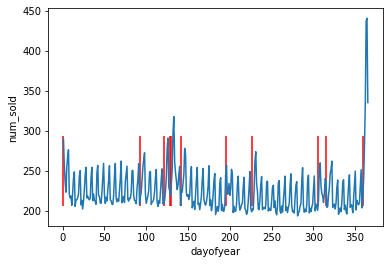

In [48]:
hol=pd.Series( list(holidays.France(years=[2018]).keys()) )
hol=pd.to_datetime(hol).dt.dayofyear

df=df_train[ (df_train.year == 2018) & (df_train.country == "France") ]
sns.lineplot(data=df,x='dayofyear',y='num_sold',ci=None);
plt.scatter(hol,(0*hol+250), marker='|', s=5000,color='red');

The sales peak always occurs about 4 days after the holiday itself. This was seen to be true for all countries and years. Furthermore, the increase in sales does not occur in a single day, it appears to happen for 2 to 4 days. This can be modelled using a gaussian function with a spread, instead of a single point.

Therefore, to create the new features with the holidays of each month, gaussian functions will be added, shifted by 4 days from the holiday itself and a half-width of two days.

Considering the holidays for each country and year, let's first create a dictionary with this info:

In [49]:
dict_holidays = {}
years=[2017,2018,2019,2020,2021]
countries=df_train.country.unique()
for y in years:
    for c in countries:
        name=c + "_" + str(y)
        hol=pd.Series( list(holidays.CountryHoliday(c,years=y).keys()) )
        hol=pd.to_datetime(hol).dt.dayofyear
        dict_holidays.update({name:list(hol)})

Now add a guassian to each holiday and each country (except for Xmas and New Year) that were filtered out in the cell above:

In [50]:
shift=5.5   # Shift in days, given that the major increase seems to occur after the holiday itself
sigma=2   # Half-width value / Spread of the gaussian function

It seems to be working. Now add a special column for Xmas, New-Year and Epifany. Let's keep in mind that one extra feature to take into account the Xmas of the year of 2016 needs to be added to reproduce the first peak (boundary issues). Let's also add a special extra weight in some other holidays that seem to have greater sales than the rest, such as "Easter" and "August_15th". Since it is difficult to pinpoint each holiday at each year and country, let's take day-of-year ranges.

In [51]:
def add_holidays(df,dict_holidays,years,countries):
    for c in countries:
        name_col="Hol_"+c
        df[name_col]=0.0
        for y in years:
            name=c + "_" + str(y)
            for mu in dict_holidays[name]:
                mask= (df.year == y) & (df.country == c)
                filtered=df[mask].dayofyear.apply(gaussians,mu=(mu+shift),sigma=sigma)
                filtered=filtered.reindex(index=np.arange(0,len(df)),fill_value=0)
                df[name_col] = df[name_col] + filtered
    
    xmas_dayofyear_2016=-5
    xmas_dayofyear=360
    new_year_dayofyear=1
    epifany_dayofyear=8

    df["xmas_2016"]=df.dayofyear.apply(gaussians,mu=(xmas_dayofyear_2016+shift),sigma=sigma)
    df["xmas"]=df.dayofyear.apply(gaussians,mu=(xmas_dayofyear+shift),sigma=sigma)
    df["new_year"]=df.dayofyear.apply(gaussians,mu=(new_year_dayofyear+shift),sigma=sigma)
    df["epifany"]=df.dayofyear.apply(gaussians,mu=(epifany_dayofyear+shift),sigma=sigma)

    masks=[]
    masks.append( (df.dayofyear > 75) & (df.dayofyear < 115) )
    masks.append( (df.dayofyear > 115) & (df.dayofyear < 150) )
    masks.append( (df.dayofyear > 210) & (df.dayofyear < 240) )
    masks.append( (df.dayofyear > 300) & (df.dayofyear < 330) )
    for i in range(0,len(masks)):
        name_special="special_"+str(i)
        for  c in countries:
            name_col="Hol_"+c
            filtered=df[masks[i]][name_col]
            filtered=filtered.reindex(index=np.arange(0,len(df)),fill_value=0)
            df[name_special]=filtered

In [52]:
add_holidays(df_days,dict_holidays,years,countries)

Let's check the 4 special weights added to different periods of the year. 

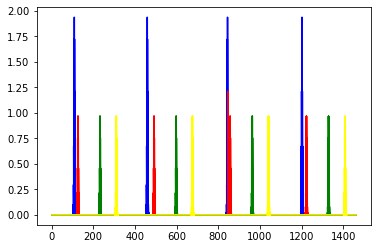

In [53]:
c=["blue","red","green","yellow"]
for i in range(4):
    name="special_"+str(i)
    plt.plot(df_days.time_days,df_days[name],color=c[i]);

Quite good. And that's it for the holidays. More could be done here, but always with a high risk of overfitting to the train data. So let's stop adding more features.

## Modelling the time series trend

Now _Statsmodel_ will be used to add each feature in a step-by-step approach, checking which features are relevant and how they change the predictions. Sonce we are fitting a square function, the square of the time (in days) will be evaluated and used in the fit.

In [54]:
df_days['time_days_sq']=df_days['time_days']**2

df_days=pd.get_dummies(df_days) # Without drop_first / the columns dropped due to redundancy will be manually selected

# Scaling that solves the problem of multicollinearity
#df_days['time_days_scaled']=df_days['time_days']/1461
#df_days['time_days_sq_scaled']=df_days['time_days_scaled']**2

### No additional features

                            OLS Regression Results                            
Dep. Variable:          sum_sales_day   R-squared:                       0.195
Model:                            OLS   Adj. R-squared:                  0.195
Method:                 Least Squares   F-statistic:                     1063.
Date:                Sat, 01 Oct 2022   Prob (F-statistic):               0.00
Time:                        17:10:10   Log-Likelihood:                -75220.
No. Observations:                8766   AIC:                         1.504e+05
Df Residuals:                    8763   BIC:                         1.505e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     8767.5686     41.379    211.884   

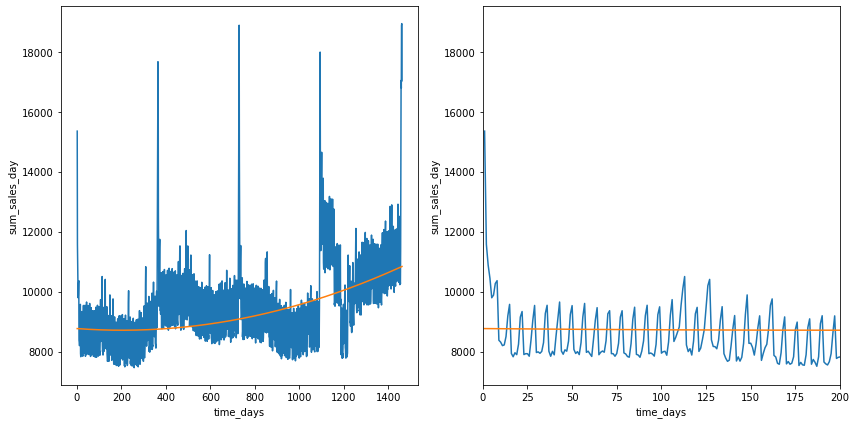

In [55]:
model = smf.ols('sum_sales_day ~ time_days + time_days_sq', data = df_days).fit()
print(model.summary())
compare_pred(df_days,model)

The warning of multicolinearity can be easily removed by rescaling the time_days variable, as comented above. It was checked that it is not harming the accuracy of the fit. 

The adjusted R2 is not great, but the fit is reasonable. We have a small contribution from the square term (0.0013). 

### Weekdays

Adding now the weekdays in the fit.

                            OLS Regression Results                            
Dep. Variable:          sum_sales_day   R-squared:                       0.430
Model:                            OLS   Adj. R-squared:                  0.430
Method:                 Least Squares   F-statistic:                     827.3
Date:                Sat, 01 Oct 2022   Prob (F-statistic):               0.00
Time:                        17:10:11   Log-Likelihood:                -73705.
No. Observations:                8766   AIC:                         1.474e+05
Df Residuals:                    8757   BIC:                         1.475e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          8690.4703     45.01

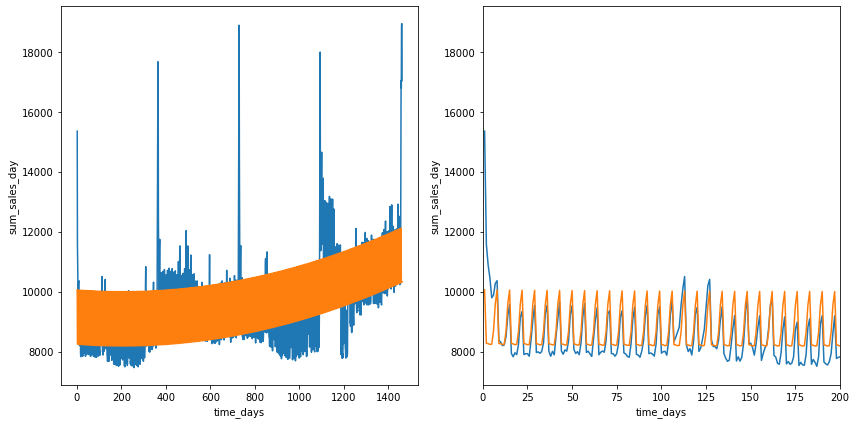

In [56]:
model = smf.ols('sum_sales_day ~ time_days + time_days_sq + weekday_Monday + \
                          weekday_Saturday + weekday_Sunday + weekday_Thursday + \
                          weekday_Tuesday + weekday_Wednesday', data = df_days).fit()
print(model.summary())
compare_pred(df_days,model)

Better, the periodicity in the week was well captured and the R2 improved a lot. Statistically speaking, all features are important. The 2nd order (0.0013) and 1st order (-0.55) magnitudes are nearly unchanged by the addition of the weekday features, so the trend is not really affected by it. This makes sense, and it a good data.

### Weekdays + Month

Adding the months:

                            OLS Regression Results                            
Dep. Variable:          sum_sales_day   R-squared:                       0.546
Model:                            OLS   Adj. R-squared:                  0.545
Method:                 Least Squares   F-statistic:                     553.3
Date:                Sat, 01 Oct 2022   Prob (F-statistic):               0.00
Time:                        17:10:12   Log-Likelihood:                -72712.
No. Observations:                8766   AIC:                         1.455e+05
Df Residuals:                    8746   BIC:                         1.456e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          8341.0323     53.34

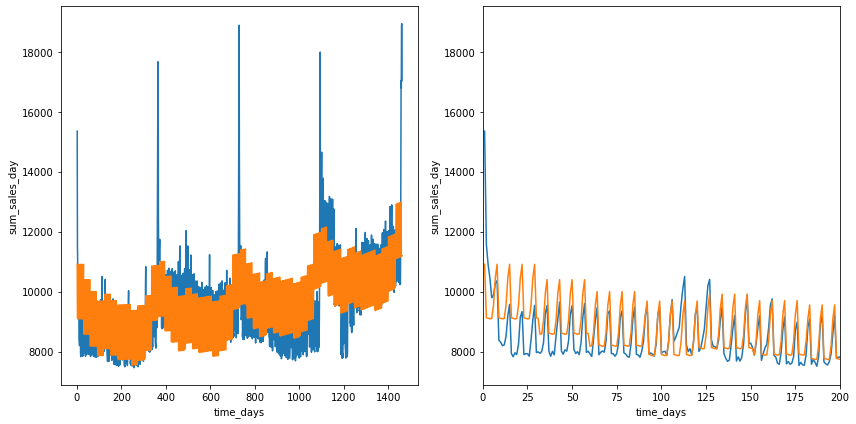

In [57]:
model = smf.ols('sum_sales_day ~ time_days + time_days_sq + weekday_Monday + \
                          weekday_Saturday + weekday_Sunday + weekday_Thursday + \
                          weekday_Tuesday + weekday_Wednesday + \
                          month_August + month_December + month_February + \
                          month_January + month_July + month_April + \
                          month_March + month_May + month_November + month_October + \
                          month_September', data = df_days).fit()
print(model.summary())
compare_pred(df_days,model)

Very good improvement again in the adjusted R2. The weekdays are all statistically relevant, and the months as well, except for April. it will not be removed at this point, since it may become relevant later on with the addition of other features.

### Weekdays + Month + Sinusoidal functions

Considering the periodic motion, the 1/2 years cyclic sales of the 4 different products are next included.

                            OLS Regression Results                            
Dep. Variable:          sum_sales_day   R-squared:                       0.607
Model:                            OLS   Adj. R-squared:                  0.606
Method:                 Least Squares   F-statistic:                     586.2
Date:                Sat, 01 Oct 2022   Prob (F-statistic):               0.00
Time:                        17:10:13   Log-Likelihood:                -72083.
No. Observations:                8766   AIC:                         1.442e+05
Df Residuals:                    8742   BIC:                         1.444e+05
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          1835.8489    851.74

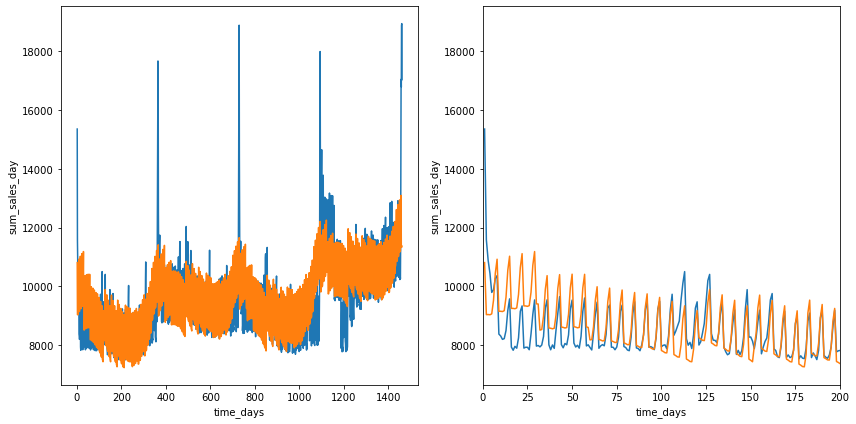

In [58]:
model = smf.ols('sum_sales_day ~ time_days + time_days_sq + weekday_Monday + \
                          weekday_Saturday + weekday_Sunday + weekday_Thursday + \
                          weekday_Tuesday + weekday_Wednesday +  month_September + \
                          month_August + month_December + month_February + \
                          month_January + month_July + month_April + \
                          month_March + month_May + month_November + month_October + \
                          sine_0 + sine_1 + sine_2 + sine_3', data = df_days).fit()
print(model.summary())
compare_pred(df_days,model)

The R2-adjusted improved again, a little bit less this time. But one can see that some of the months are now not so statistically relevant, and could probaly be removed without any loss of accuracy. Furthermore, there is no need of 4 sine functions, since one is reduntant. So one of them can be dropped. This will be done later on.

### Weekdays + Month + Sinusoidal functions + Holidays

Now let's add the holidays.

                            OLS Regression Results                            
Dep. Variable:          sum_sales_day   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     1143.
Date:                Sat, 01 Oct 2022   Prob (F-statistic):               0.00
Time:                        17:10:14   Log-Likelihood:                -68434.
No. Observations:                8766   AIC:                         1.369e+05
Df Residuals:                    8728   BIC:                         1.372e+05
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          3236.7017    570.27

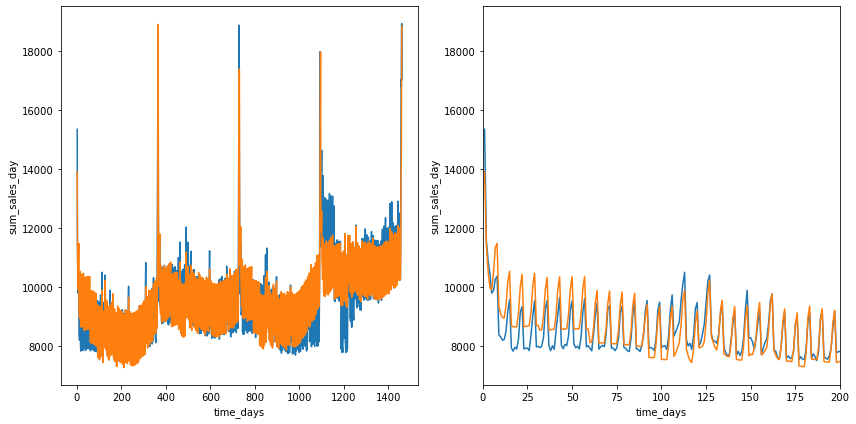

In [59]:
model = smf.ols('sum_sales_day ~ time_days + time_days_sq + weekday_Monday + \
                          weekday_Saturday + weekday_Sunday + weekday_Thursday + \
                          weekday_Tuesday + weekday_Wednesday +  month_September + \
                          month_August + month_December + month_February + \
                          month_January + month_July + month_April + \
                          month_March + month_May + month_November + month_October + \
                          sine_0 + sine_1 + sine_2 + sine_3 + \
                          Hol_Belgium + Hol_France + Hol_Germany + Hol_Italy + \
                          Hol_Poland + Hol_Spain + xmas_2016 + xmas + new_year + \
                          epifany + special_0 +  special_1 +  special_2 +  special_3', data = df_days).fit()
print(model.summary())
compare_pred(df_days,model)

A very good improvement in the adjusted-R2 metric. 

One can see that the overall shape of the time series is well reproduced. The year of 2020, however, shown a large increase in the months of January/February ( before covid), and a decrease during the lockdown, mostly between April-May. And it seems to show a _Pos-Lockdown_ small growth afterwars, which would be a increase in sales due to the lack os sales during the lockdown. (I'm only guessing). 

### Weekdays + Month + Sinusoidal functions + Holidays + Covid

Now is one of the most tricky parts about this problem. How to accurately simulate the effects of COVID. Adding too many features might easily cause overfitting to the train data. So one needs to be wise as to add relevant information wihout improving too much. In fact, adding 12 features for covid (on for each month of 2020) can raise the R2-adjusted to 0.96, but the final score in the 2021 data is just terrible (I tried).

So let'a add the covid element to the model taking into account a pre-lockdown period (January-February), the lockdown (April-May), the pos-lockdown (June-August) and pos-covid. The pos-lockdown could be extended to 2021, or not. Difficult to predict. The whole 2021 year is very difficult to guess, so only approximations can be done.

In [60]:
def covid_fun(df):
    df['pre_lockdown']=df.date.apply(lambda x: 1 if (x >= pd.Timestamp(2020,1,1)) & (x < pd.Timestamp(2020,3,1)) else 0)
    df['lockdown_March']=df.date.apply(lambda x: 1 if (x >= pd.Timestamp(2020,3,1)) & (x < pd.Timestamp(2020,4,1)) else 0)    
    df['lockdown_April']=df.date.apply(lambda x: 1 if (x >= pd.Timestamp(2020,4,1)) & (x < pd.Timestamp(2020,5,1)) else 0)
    df['lockdown_May']=df.date.apply(lambda x: 1 if (x >= pd.Timestamp(2020,5,1)) & (x < pd.Timestamp(2020,6,1)) else 0)
    df['lockdown_June']=df.date.apply(lambda x: 1 if (x >= pd.Timestamp(2020,6,1)) & (x < pd.Timestamp(2020,7,1)) else 0)
    df['pos_lockdown']=df.date.apply(lambda x: 1 if (x >= pd.Timestamp(2020,7,1)) & (x < pd.Timestamp(2020,10,1)) else 0)
    df['pos_covid']=df.date.apply(lambda x: 1 if x >= pd.Timestamp(2020,10,1) else 0)

                            OLS Regression Results                            
Dep. Variable:          sum_sales_day   R-squared:                       0.927
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                     2534.
Date:                Sat, 01 Oct 2022   Prob (F-statistic):               0.00
Time:                        17:10:17   Log-Likelihood:                -64673.
No. Observations:                8766   AIC:                         1.294e+05
Df Residuals:                    8721   BIC:                         1.298e+05
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          5507.8139    428.23

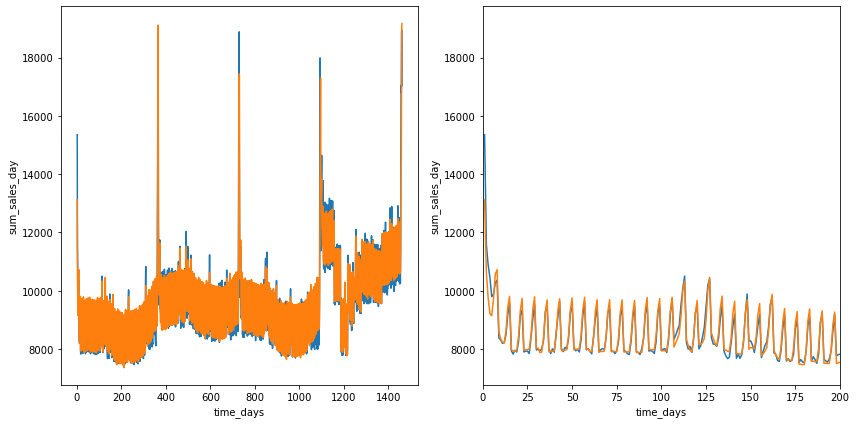

In [61]:
covid_fun(df_days)

model = smf.ols('sum_sales_day ~ time_days + time_days_sq + weekday_Monday + \
                          weekday_Saturday + weekday_Sunday + weekday_Thursday + \
                          weekday_Tuesday + weekday_Wednesday +  month_September + \
                          month_August + month_December + month_February + \
                          month_January + month_July + month_April + \
                          month_March + month_May + month_November + month_October + \
                          sine_0 + sine_1 + sine_2 + sine_3 + \
                          pre_lockdown + lockdown_March + lockdown_April + lockdown_May + \
                          lockdown_June + pos_lockdown + pos_covid + \
                          Hol_Belgium + Hol_France + Hol_Germany + Hol_Italy + \
                          Hol_Poland + Hol_Spain + xmas_2016 + xmas + new_year + \
                          epifany + special_0 +  special_1 +  special_2 +  special_3', data = df_days).fit()
print(model.summary())
compare_pred(df_days,model)

A very good R2-adjusted, which is dangerous, but the curve makes sense. Many features have a statistically irrelevant contribution, so let's remove some of them and see if the accuracy changes:

### Final quadratic and linear models

                            OLS Regression Results                            
Dep. Variable:          sum_sales_day   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.923
Method:                 Least Squares   F-statistic:                     3305.
Date:                Sat, 01 Oct 2022   Prob (F-statistic):               0.00
Time:                        17:10:18   Log-Likelihood:                -64894.
No. Observations:                8766   AIC:                         1.299e+05
Df Residuals:                    8733   BIC:                         1.301e+05
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          5693.8595     62.50

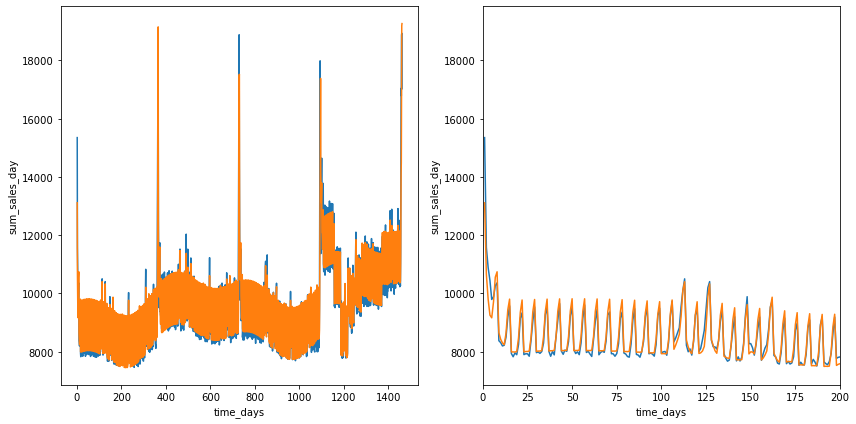

In [62]:
model_quad = smf.ols('sum_sales_day ~ time_days + time_days_sq + weekday_Monday + \
                          weekday_Saturday + weekday_Sunday + weekday_Thursday + \
                          weekday_Tuesday + weekday_Wednesday + \
                          sine_1 + sine_2 + sine_3 + \
                          pre_lockdown + lockdown_March + lockdown_April + lockdown_May + \
                          lockdown_June + pos_lockdown + pos_covid + \
                          Hol_Belgium + Hol_France + Hol_Germany + Hol_Italy + \
                          Hol_Poland + Hol_Spain + xmas_2016 + xmas + new_year + \
                          epifany + special_0 +  special_1 +  special_2 +  special_3', data = df_days).fit()
print(model_quad.summary())
compare_pred(df_days,model_quad)

Nearly the same accuracy removing more than 10 features. The contribution of the quadractic term (-0.001) is very small, so a simpler linear regression will probably have almost the same accuracy.

                            OLS Regression Results                            
Dep. Variable:          sum_sales_day   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                     3260.
Date:                Sat, 01 Oct 2022   Prob (F-statistic):               0.00
Time:                        17:10:19   Log-Likelihood:                -65077.
No. Observations:                8766   AIC:                         1.302e+05
Df Residuals:                    8734   BIC:                         1.304e+05
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          5245.5372     59.26

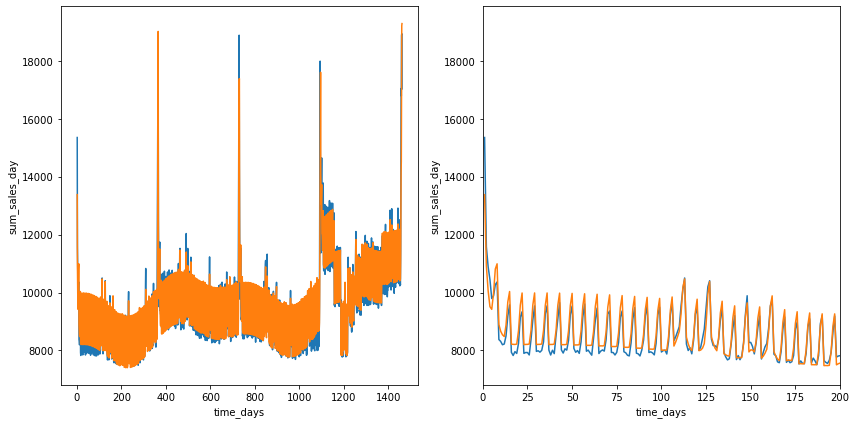

In [63]:
model_linear = smf.ols('sum_sales_day ~ time_days + weekday_Monday + \
                          weekday_Saturday + weekday_Sunday + weekday_Thursday + \
                          weekday_Tuesday + weekday_Wednesday + \
                          sine_1 + sine_2 + sine_3 + \
                          pre_lockdown + lockdown_March + lockdown_April + lockdown_May + \
                          lockdown_June + pos_lockdown + pos_covid + \
                          Hol_Belgium + Hol_France + Hol_Germany + Hol_Italy + \
                          Hol_Poland + Hol_Spain + xmas_2016 + xmas + new_year + \
                          epifany + special_0 +  special_1 +  special_2 +  special_3', data = df_days).fit()
print(model_linear.summary())
compare_pred(df_days,model_linear)

Indeed, very similar. The shape of the curve changed a bit, however, and it remain to be seen if the linear regression is better than the quadraic one for the 2021 curve, where the changes will be larger. So both models will be kept for now.

As a curiosity, let's see the trend disregarding the 2020 year.

In [64]:
df_temp=df_days[df_days.year < 2020]

                            OLS Regression Results                            
Dep. Variable:          sum_sales_day   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                     3260.
Date:                Sat, 01 Oct 2022   Prob (F-statistic):               0.00
Time:                        17:10:19   Log-Likelihood:                -65077.
No. Observations:                8766   AIC:                         1.302e+05
Df Residuals:                    8734   BIC:                         1.304e+05
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          5245.5372     59.26

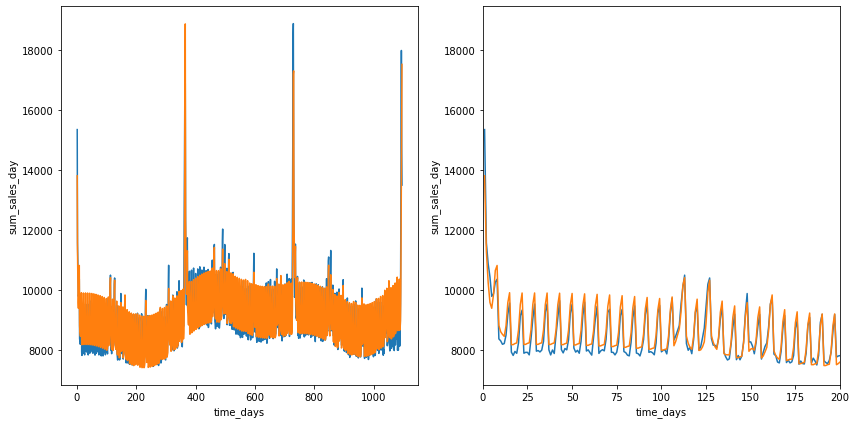

In [65]:
model_temp = smf.ols('sum_sales_day ~ time_days + weekday_Monday + \
                          weekday_Saturday + weekday_Sunday + weekday_Thursday + \
                          weekday_Tuesday + weekday_Wednesday + \
                          sine_1 + sine_2 + sine_3 + \
                          pre_lockdown + lockdown_March + lockdown_April + lockdown_May + \
                          lockdown_June + pos_lockdown + pos_covid + \
                          Hol_Belgium + Hol_France + Hol_Germany + Hol_Italy + \
                          Hol_Poland + Hol_Spain + xmas_2016 + xmas + new_year + \
                          epifany + special_0 +  special_1 +  special_2 +  special_3', data = df_temp).fit()
print(model_linear.summary())
compare_pred(df_temp,model_temp)

So the linear contribution that represent the increase in sales (time_days coefficient) is the nearly the same removing the 2020 year, and this is interesting. So the model, as it is, assumes a regular increase in sales each year, and even though the 2020 year was chaotic, the linear increase was not affected by it.

## The predicitons

Let's evaluate and check the predicitons for 2021.

In [66]:
df_test['weekday']=df_test['weekday'].map(dict_toweekday)
df_days_test=df_test.copy()
df_days_test['time_days_sq']=df_days_test['time_days'] ** 2

covid_fun(df_days_test)
years=[2021]
add_sines(df_days_test,leap=leap_year)
add_holidays(df_days_test,dict_holidays,years,countries)

df_days_test=pd.get_dummies(df_days_test)

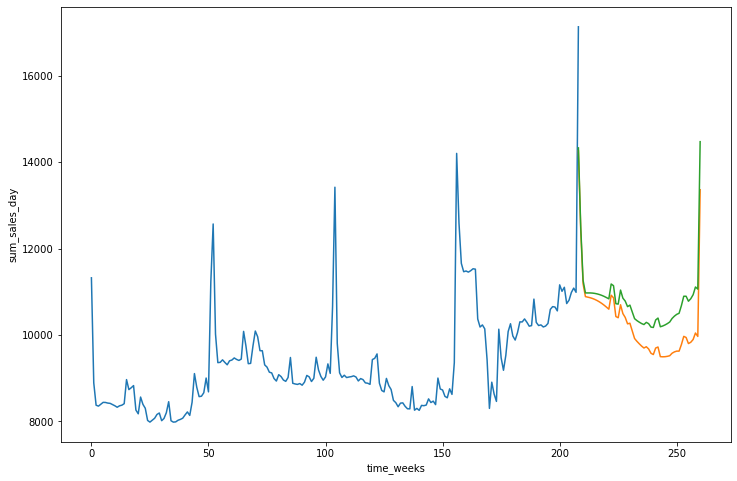

In [67]:
quad_total_sales_pred = model_quad.predict(df_days_test)
lin_total_sales_pred = model_linear.predict(df_days_test)

plt.figure(figsize=(12,8))
sns.lineplot(data=df_days,x='time_weeks',y='sum_sales_day',ci=None);
sns.lineplot(data=df_days_test,x='time_weeks',y=quad_total_sales_pred,ci=None);
sns.lineplot(data=df_days_test,x='time_weeks',y=lin_total_sales_pred,ci=None);

So the quadratic function result in a much lower number of sales, which does not seem correct considering the other years. So let's abandon this representation and keep only the linear model.

In [68]:
df_test['linear_pred']=lin_total_sales_pred
df_test['final_linear_pred']=df_test['linear_pred']*df_test['predicted_fraction']

# Submission

In [69]:
sample_submission_df = pd.read_csv('./sample_submission.csv')
sample_submission_df['num_sold'] = df_test['final_linear_pred']
sample_submission_df.to_csv('./submission.csv', index=False)
sample_submission_df.tail()

,row_id,num_sold
17515,87643,718.321896
17516,87644,231.727286
17517,87645,180.720880
17518,87646,153.704785
17519,87647,249.818447


In [74]:
df_test = pd.read_csv('./test.csv.zip').drop('row_id', axis=1)

In [75]:
df_test

,date,country,store,product
0,2021-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques
1,2021-01-01,Belgium,KaggleMart,Kaggle Getting Started
2,2021-01-01,Belgium,KaggleMart,Kaggle Recipe Book
3,2021-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose
4,2021-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques
...,...,...,...,...
17515,2021-12-31,Spain,KaggleMart,Kaggle for Kids: One Smart Goose
17516,2021-12-31,Spain,KaggleRama,Kaggle Advanced Techniques
17517,2021-12-31,Spain,KaggleRama,Kaggle Getting Started
17518,2021-12-31,Spain,KaggleRama,Kaggle Recipe Book
